# Tdem Data Point Class

## Tdem Data contains entire data sets
## Tdem Data Points can forward model and evaluate themselves

### TdemData is an extension to the [Data](Data.ipynb) Class

##### Back to [Main](../../PackageInfo.ipynb)

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from os.path import join
import numpy as np
import h5py
import matplotlib.pyplot as plt
from geobipy import hdfRead
from geobipy import TdemData
from geobipy import TdemDataPoint
from geobipy import Model1D
from geobipy import StatArray

In [2]:
# The data file name
dataFile=[join('supplementary','Data','Skytem_High.txt'), join('supplementary','Data','Skytem_Low.txt')]
# The EM system file name
systemFile=[join('supplementary','Data','SkytemHM-SLV.stm'), join('supplementary','Data','SkytemLM-SLV.stm')]

## Initialize and read an EM data set

In [3]:
D = TdemData()
D.read(dataFile, systemFile)

[None, None]


## Summarize the Data

## Grab a measurement from the data set

EM Data Point: 
x: :[431112.2]
y: :[4194346.5]
z: :[36.7]
elevation: :[100101.]
Name:  Time Domain Data
    Units: $\frac{V}{Am^{4}}$
    Shape: (60,)
   Values: [nan nan nan ... nan nan nan]
No attached prior 
No attached proposal 
Name:  Predicted Data
    Units: $\frac{V}{Am^{4}}$
    Shape: (60,)
   Values: [0. 0. 0. ... 0. 0. 0.]
No attached prior 
No attached proposal 
Name:  Standard Deviation
    Units: $\frac{V}{Am^{4}}$
    Shape: (60,)
   Values: [1.e-12 1.e-12 1.e-12 ... 1.e-12 1.e-12 1.e-12]
No attached prior 
No attached proposal 



<IPython.core.display.Javascript object>


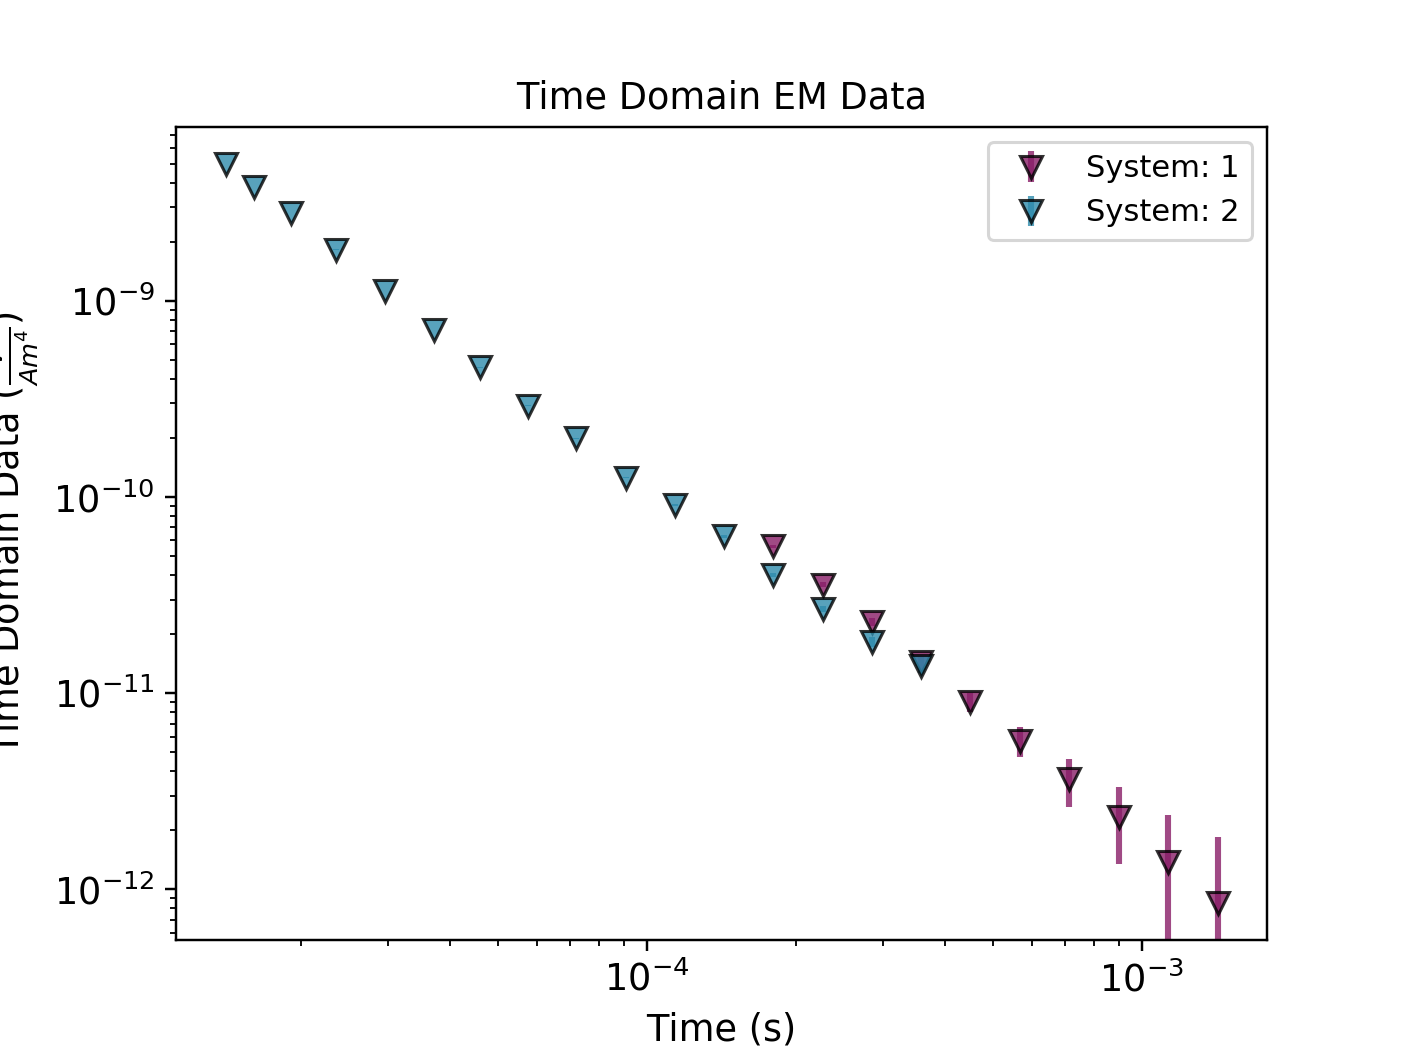

In [4]:
P = D.getDataPoint(0)
P._std[:] = 1e-12
P.summary()
plt.figure()
P.plot()

## We can forward model the EM response of a 1D layered earth <a href="../Model/Model1D.ipynb">Model1D</a>

<IPython.core.display.Javascript object>


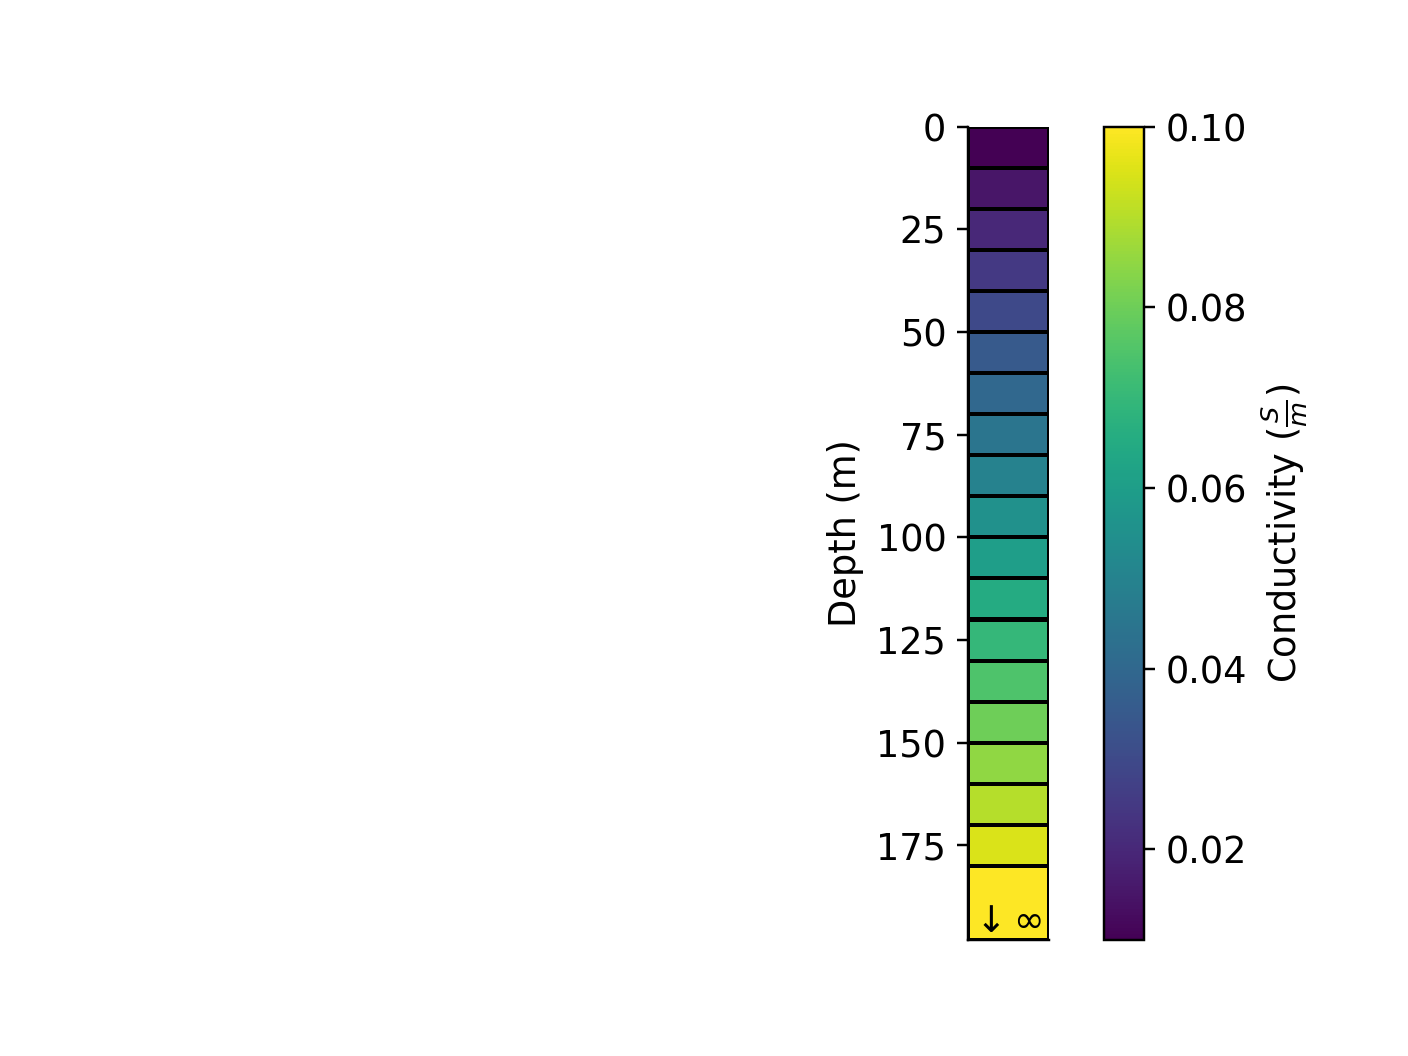

In [5]:
par = StatArray(np.linspace(0.01, 0.1, 19), "Conductivity", "$\\frac{S}{m}$")
thk = StatArray(np.ones(18) * 10.0)
mod = Model1D(nCells = 19, parameters=par, thickness=thk)
plt.figure()
mod.pcolor(grid=True)

## Compute and plot the data from the model

In [6]:
%%time
P.forward(mod)

CPU times: user 25.9 ms, sys: 2.89 ms, total: 28.8 ms
Wall time: 7 ms


<IPython.core.display.Javascript object>


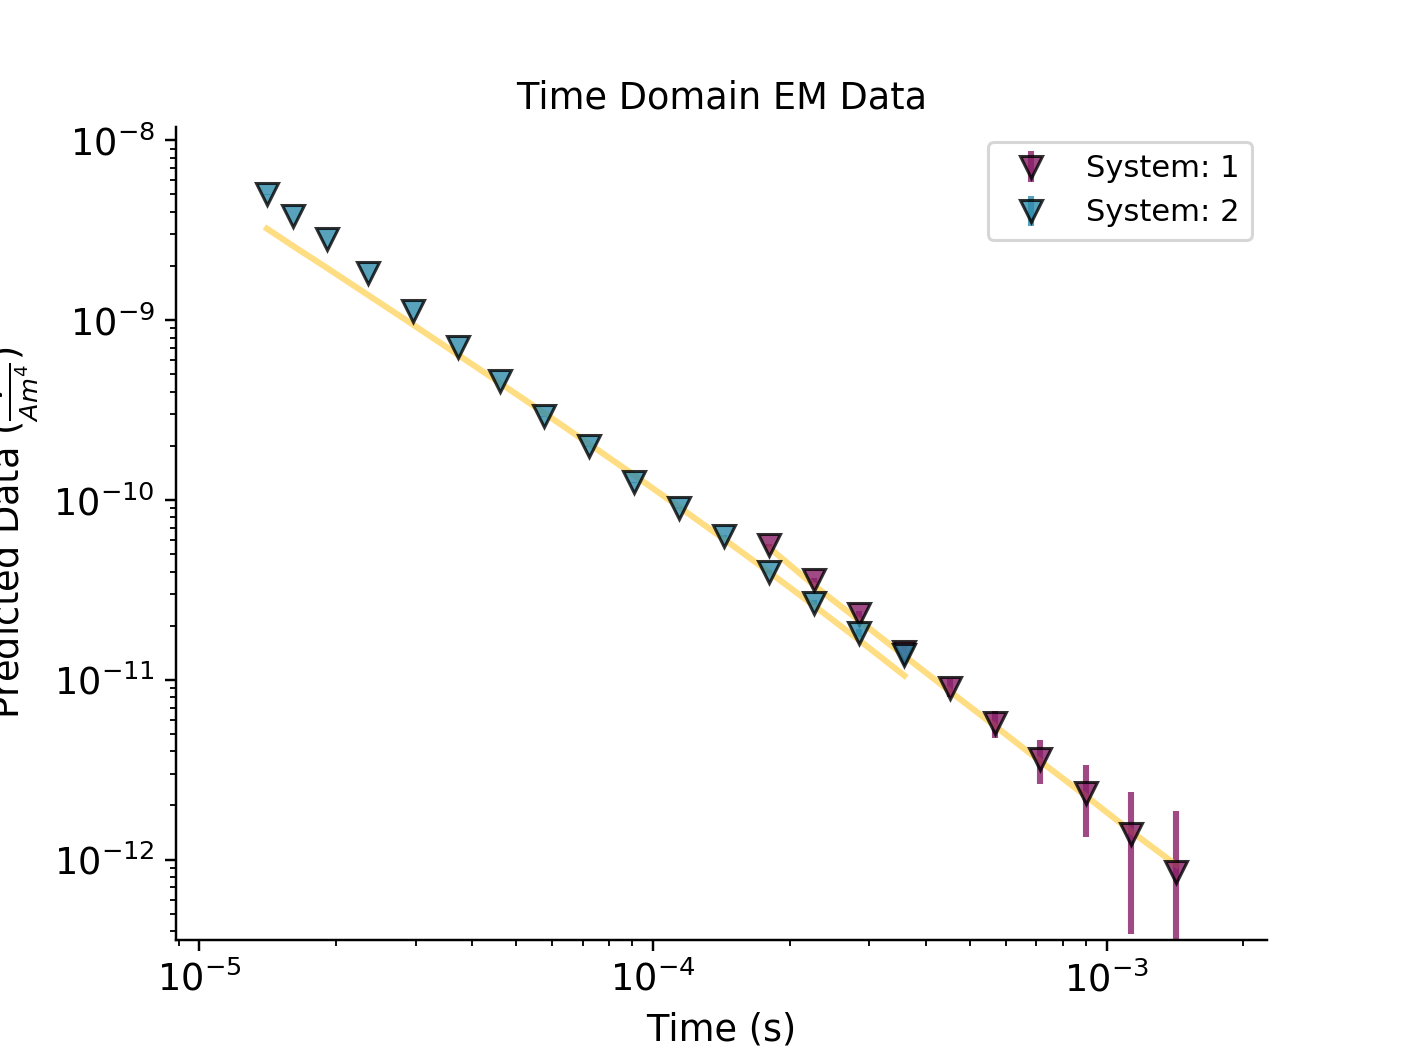

In [7]:
P.forward(mod)
plt.figure()
P.plot()
P.plotPredicted()

<IPython.core.display.Javascript object>


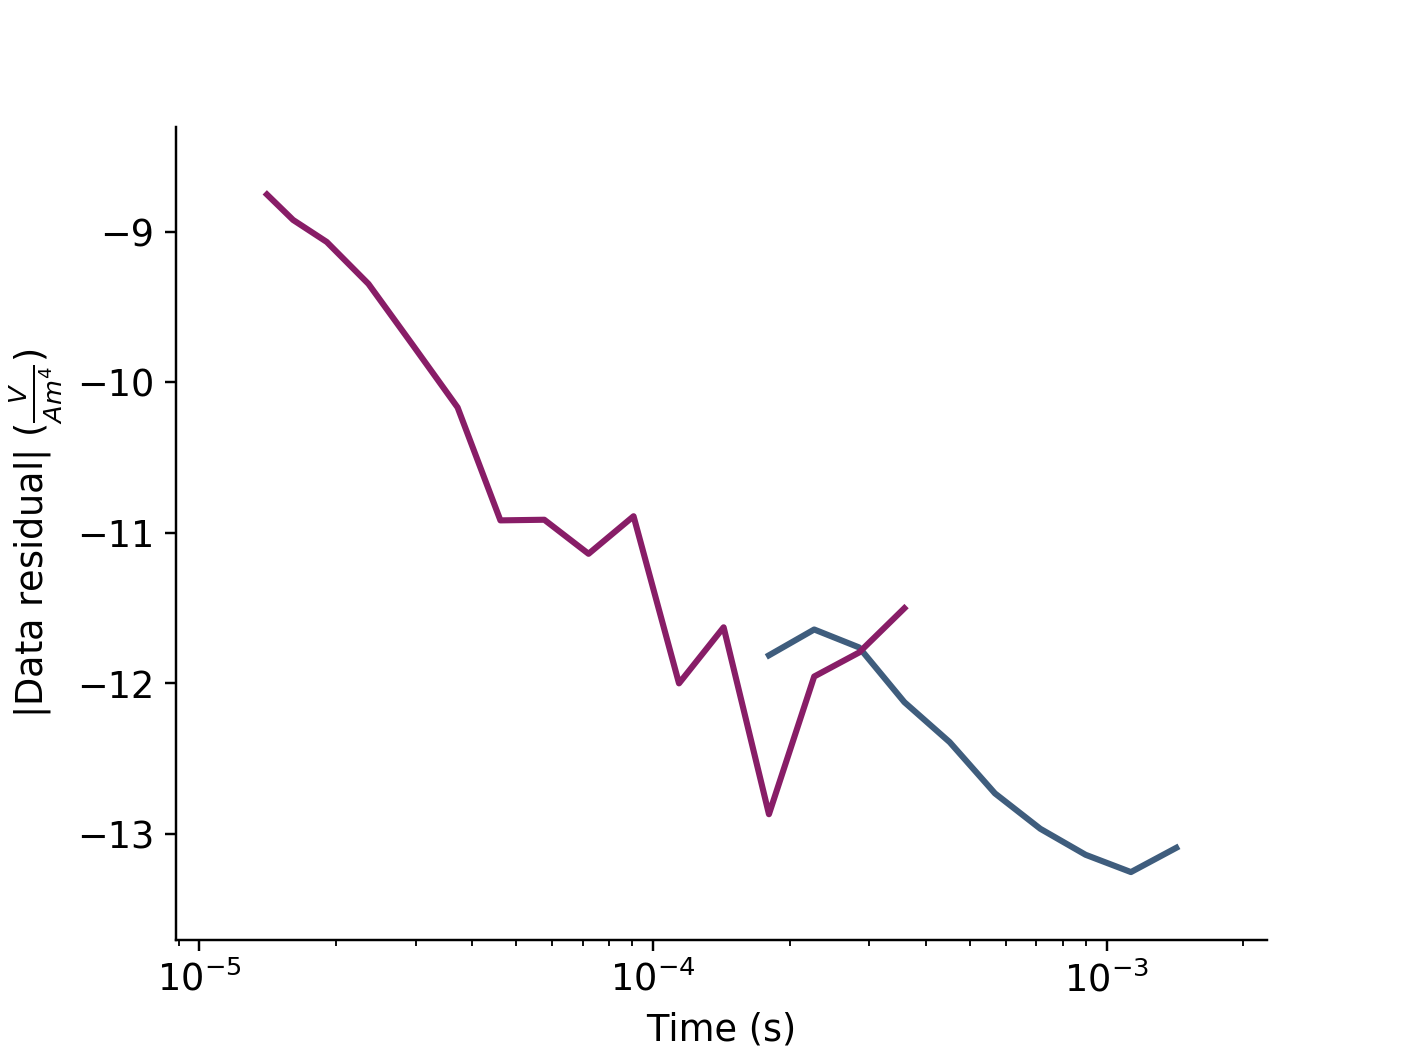

In [8]:
plt.figure()
P.plotDataResidual(xscale='log', log=10)

## The errors are set to zero right now, so lets change that

In [9]:
# Set the Prior
P._predictedData.setPrior('MVNormalLog' ,P._data[P.iActive], P._std[P.iActive]**2.0)
#P.updateErrors(option=2, err=P.s[:], relativeErr=[0.05,0.05], additiveErr=[1e-12,1e-13])

## With forward modelling, we can solve for the best fitting halfspace model

0.02009233002565048


<IPython.core.display.Javascript object>


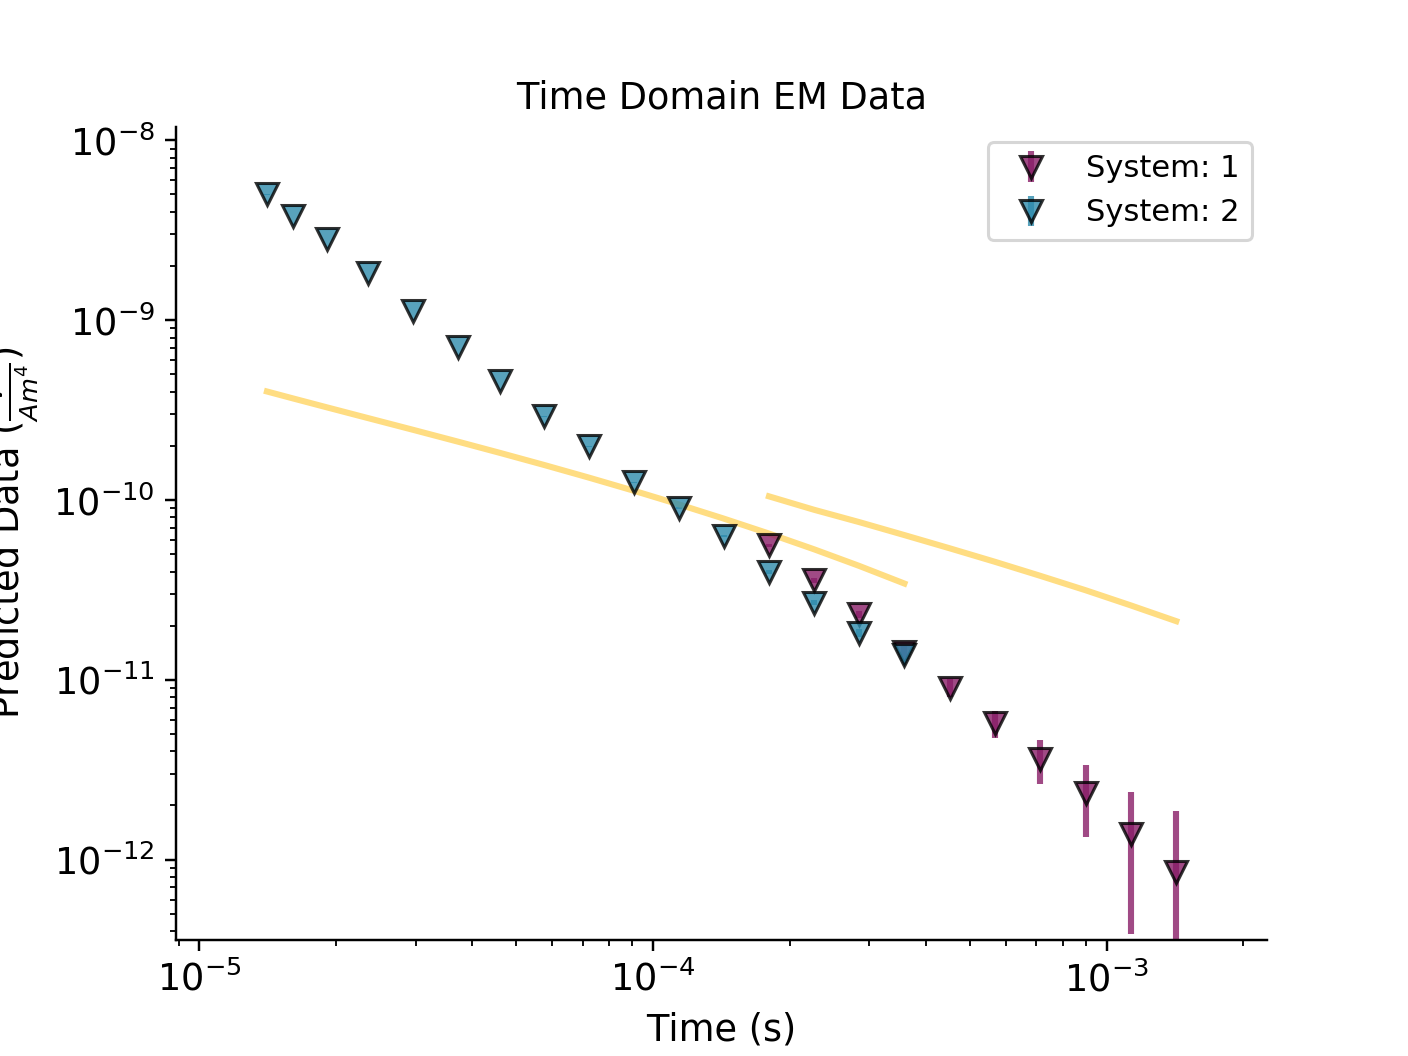

In [10]:
HSconductivity=P.FindBestHalfSpace()
print(HSconductivity)
plt.figure()
P.plot(withErrorBars=True)
P.plotPredicted()

<IPython.core.display.Javascript object>


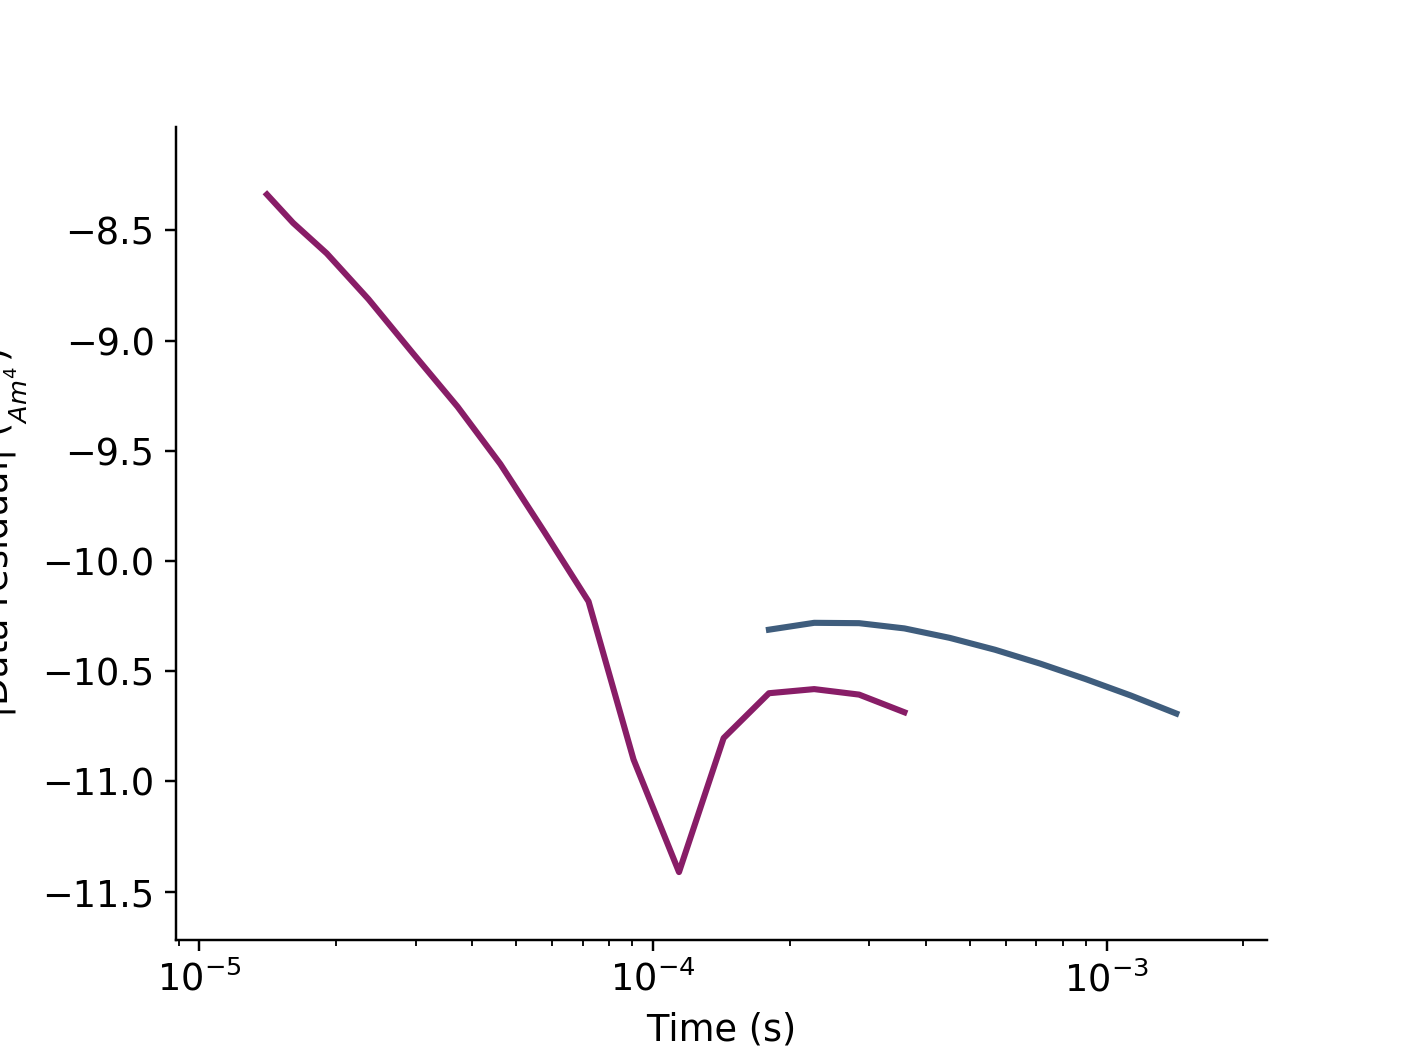

In [11]:
plt.figure()
P.plotDataResidual(xscale='log', log=10)

## Compute the misfit between observed and predicted data

In [12]:
print(P.dataMisfit())

6515.649337393108


## Plot the misfits for a range of half space conductivities

<IPython.core.display.Javascript object>


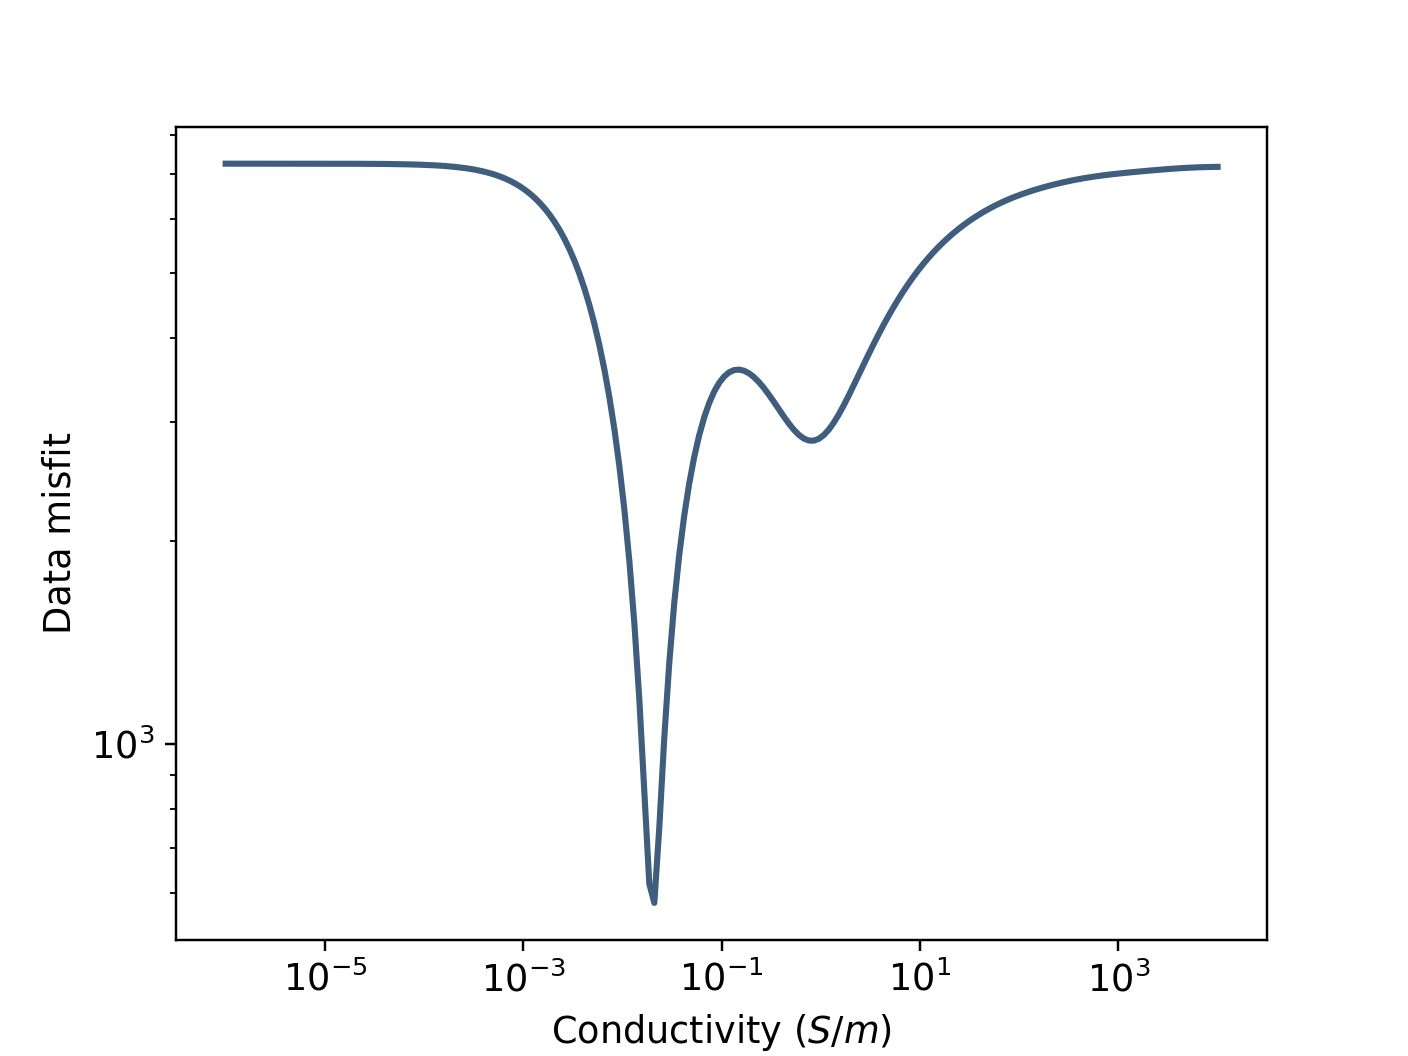

In [13]:
plt.figure()
P.plotHalfSpaceResponses(-6.0,4.0,200)

## Compute the sensitivity matrix for a given model

<IPython.core.display.Javascript object>


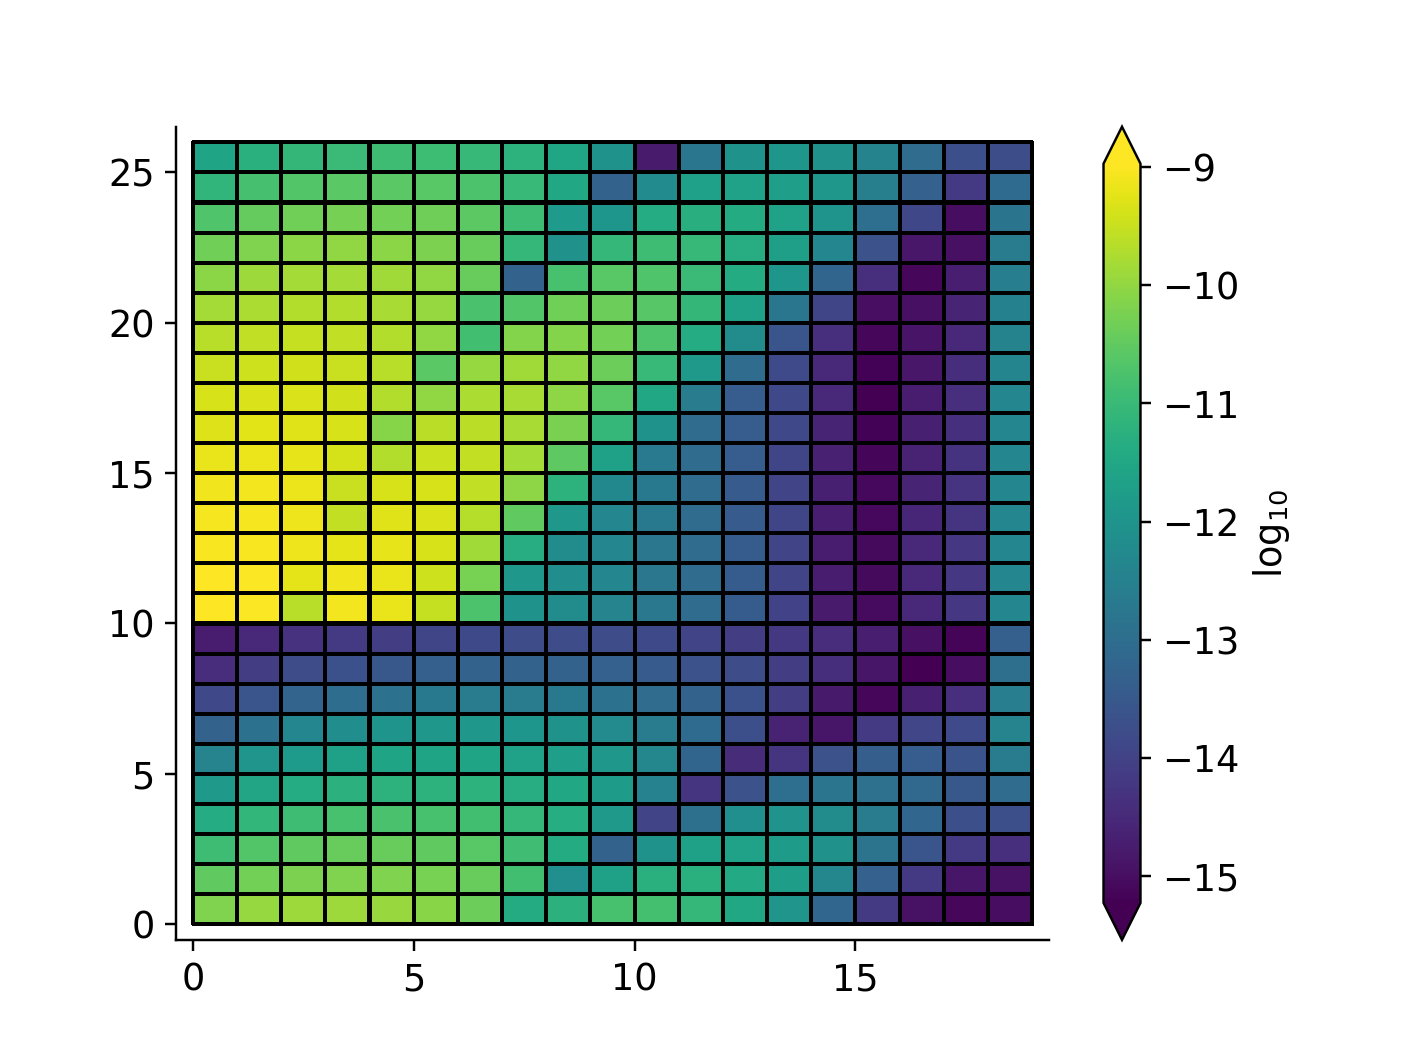

In [14]:
sensitivityMatrix = P.sensitivity(mod)
J = StatArray(np.abs(sensitivityMatrix),'|Sensitivity|')
plt.figure()
J.pcolor(grid=True, log=10, equalize=True, linewidth=1)

In [15]:
%%time
sensitivityMatrix = P.sensitivity(mod)

CPU times: user 41.3 ms, sys: 691 µs, total: 42 ms
Wall time: 41.4 ms


## We can save the FdemDataPoint to a HDF file

In [16]:
with h5py.File('TdemDataPoint.h5','w') as hf:
    P.createHdf(hf, 'tdp')
    P.writeHdf(hf, 'tdp')

## And then read it in

In [17]:
P1=hdfRead.readKeyFromFiles('TdemDataPoint.h5','/','tdp', sysPath=join('supplementary','Data'))

In [18]:
P1.summary()

EM Data Point: 
x: :[431112.2]
y: :[4194346.5]
z: :[36.7]
elevation: :[100101.]
Name:  Time Domain Data
    Units: $\frac{V}{Am^{4}}$
    Shape: (60,)
   Values: [nan nan nan ... nan nan nan]
No attached prior 
No attached proposal 
Name:  Predicted Data
    Units: $\frac{V}{Am^{4}}$
    Shape: (60,)
   Values: [-7.52479075e-09 -0.00000000e+00 -8.00230165e-09 ...  1.63911837e-12
  1.19336078e-12  9.47938324e-13]
No attached prior 
No attached proposal 
Name:  Standard Deviation
    Units: $\frac{V}{Am^{4}}$
    Shape: (60,)
   Values: [1.e-12 1.e-12 1.e-12 ... 1.e-12 1.e-12 1.e-12]
No attached prior 
No attached proposal 

